＜本ノートブックの目的＞

+ ライブラリdiffusersの仕組みを理解した上で、自分の手で画像生成モデルの学習を行い、それを使ってみる

＜モデル概要＞

diffusersではモデルは以下のように、構成される

+ ModelとSchedulerを定義することで、一連の画像生成パイプラインとして利用することができる

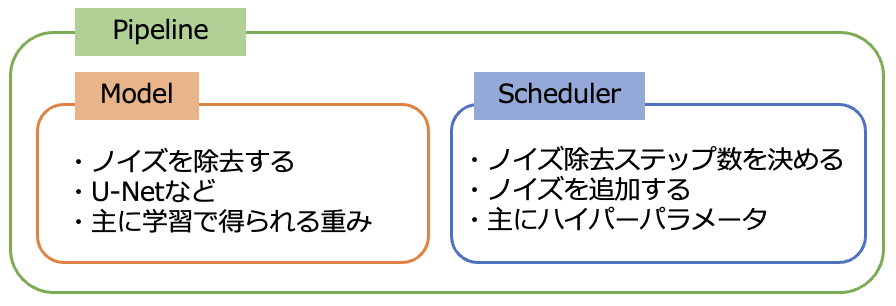

以下、colabで動作することを確認済

# 事前準備

In [2]:
#!pip install diffusers==0.1.3

%%capture
!pip install diffusers[training]==0.1.3
!pip install accelerate
!pip install datasets

!sudo apt -qq install git-lfs
!git config --global credential.helper store

以下で紹介する処理では、HaggingFaceの環境内にモデルを格納していくので、事前に作成したアカウントのトークンによるログインが必要です。

   アカウント作成：https://huggingface.co/join

また、次のセルでトークンを記入する際に、読み込み用（READ）では後にエラーが発生するので、書き込み用（WRITE）のトークンを記入する必要があります

In [3]:
from huggingface_hub import notebook_login
notebook_login()

上のセルで期待される画面が表示されなかったので、コマンドで実施

In [4]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


# Pipelines

In [5]:
from diffusers import DDPMPipeline

[学習済みモデル一覧](https://huggingface.co/models?pipeline_tag=unconditional-image-generation&sort=downloads)


## google/ddpm-celebahq-256

+ most downloaded model

+ 有名人の顔画像のデータセットをもとに学習したモデル

https://huggingface.co/datasets/huggan/CelebA-HQ


In [6]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/93.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/94.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

### データの確認

既存のパイプラインを実行するだけで、インプットを用意せずともランダム生成されたノイズをdiffusion modelに投入し画像を得ることができる

  0%|          | 0/1000 [00:00<?, ?it/s]

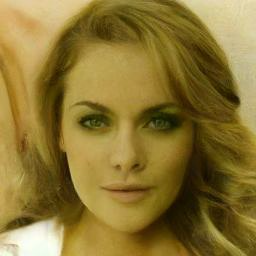

In [ ]:
images = image_pipe()["sample"]
images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

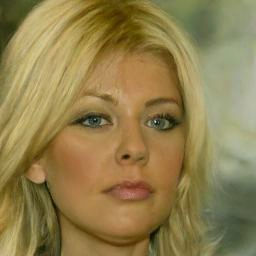

In [ ]:
images = image_pipe()["sample"]
images[0]

In [ ]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.1.3",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

# Training Model


+ 1000枚程度の蝶の画像

+ サイズがバラバラ

https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset

## confing 

In [13]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # 生成される画像サイズ
    train_batch_size = 16
    eval_batch_size = 16  # 評価時に使用する画像数
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `混合精度とは、 16 ビットと 32 ビット浮動小数点型の両方を使ってモデルのトレーニングを高速化し、使用するメモリを少なくする手法です
    output_dir = 'ddpm-butterflies-128'  # HF Hub内でのディレクトリ
    push_to_hub = True  # HF Hubにpushする場合True
    hub_private_repo = False  
    overwrite_output_dir = True 
    seed = 0

config = TrainingConfig()

## Loading the dataset

In [14]:
from datasets import load_dataset

config.dataset = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset, split="train")

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-dca27cc6049931aa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [15]:
dataset.shape

(1000, 18)

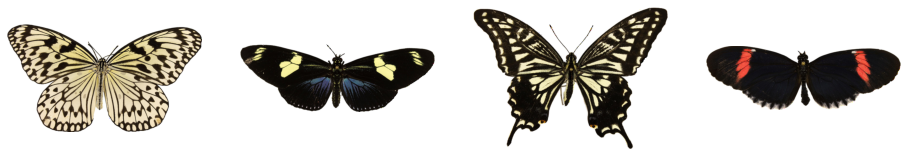

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [17]:
#input画像のサイズを揃える
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

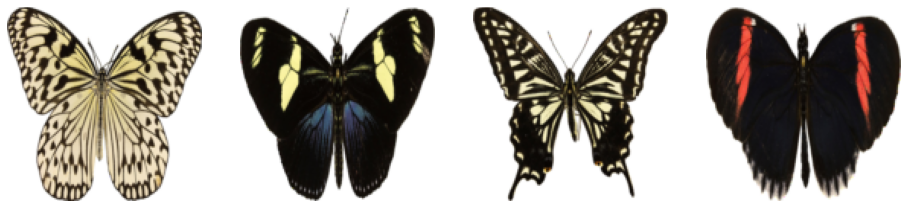

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [19]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Difining model

In [20]:
image_pipe.unet.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [21]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # 生成する画像サイズ
    in_channels=3,  # RGB 
    out_channels=3,  # inputと同じ
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

## Difining noise scheduler

In [54]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

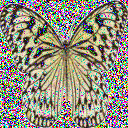

In [25]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [26]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps)["sample"]
loss = F.mse_loss(noise_pred, noise)

## training

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)


from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    )["sample"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [28]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps)["sample"]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Cloning https://huggingface.co/ny7777/ddpm-butterflies-128 into local empty directory.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0009.png', 'samples/0019.png', 'samples/0029.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0019.png:   1%|          | 3.34k/501k [00:00<?, ?B/s]

Upload file samples/0029.png:   1%|          | 3.34k/531k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1660977041.d1359beb0d01.74.0:   1%|1         | 3.34k/234k […

Upload file samples/0009.png:   1%|          | 3.34k/508k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ny7777/ddpm-butterflies-128
   94ccf3f..53485f0  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ny7777/ddpm-butterflies-128
   94ccf3f..53485f0  main -> main

To https://huggingface.co/ny7777/ddpm-butterflies-128
   53485f0..84d154e  main -> main

   53485f0..84d154e  main -> main



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0039.png', 'samples/0049.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0049.png:   1%|          | 3.34k/494k [00:00<?, ?B/s]

Upload file samples/0039.png:   1%|          | 3.34k/487k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1660977041.d1359beb0d01.74.0:   1%|          | 3.34k/390k […

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ny7777/ddpm-butterflies-128
   84d154e..28f4b43  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ny7777/ddpm-butterflies-128
   84d154e..28f4b43  main -> main



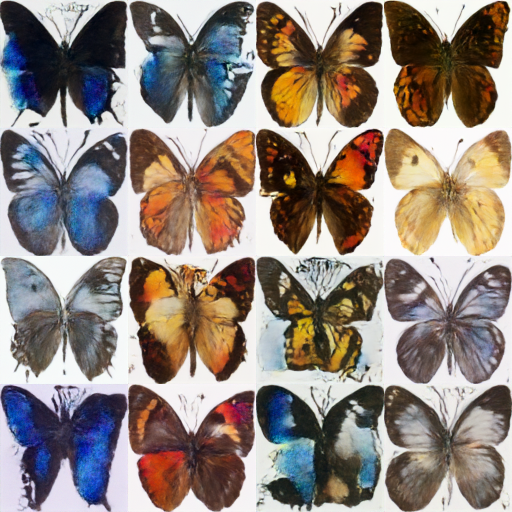

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

## use model

In [ ]:
model_id = 'ny7777/ddpm-butterflies-128'
pipeline = DDPMPipeline.from_pretrained(model_id)

Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/400k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/544k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/506k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

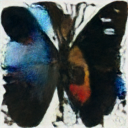

In [ ]:
image = pipeline()["sample"]
image[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

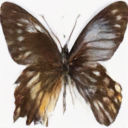

In [ ]:
image = pipeline()["sample"]
image[0]

# Training Model2

世の中に存在しないポケモンを生成してくれるモデルを作ってみよう

https://huggingface.co/datasets/huggan/pokemon

## Loading the datasets

In [30]:
from datasets import load_dataset

config.dataset = "huggan/pokemon"
dataset = load_dataset(config.dataset, split="train")

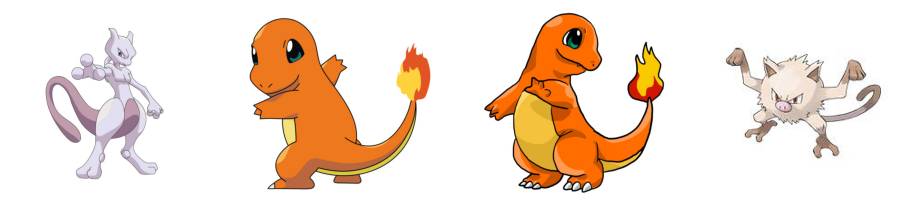

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## use model

Training Modelで行った学習方法をもとに、colab上でモデルの学習を実施

In [36]:
model_id = 'ny7777/ddpm-pokemon-128'
pipeline = DDPMPipeline.from_pretrained(model_id)

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

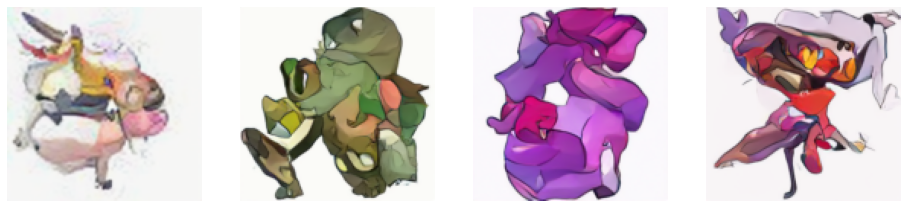

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    image = pipeline()["sample"]
    axs[i].imshow(image[0])
    axs[i].set_axis_off()
fig.show()

＜生成された画像について＞

+ 進化途中で止められたみたいで、クオリティが高いとは言い難い

+ 顔や目が無いことが大きな原因か

+ 十分な学習が行えていないことがこのクオリティに繋がった可能性が考えられる

## 別のユーザーが公開していたパイプラインも使ってみる

In [52]:
model_id = 'mrm8488/ddpm-ema-pokemon-v2-64'
pipeline = DDPMPipeline.from_pretrained(model_id)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

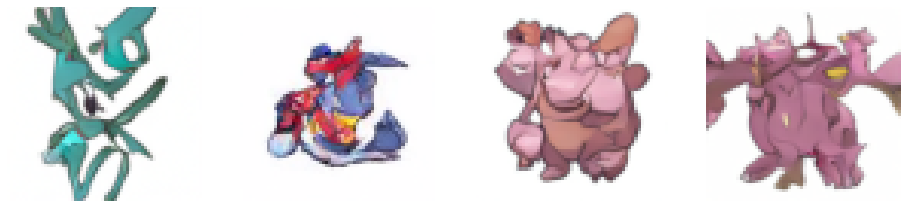

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    image = pipeline()["sample"]
    axs[i].imshow(image[0])
    axs[i].set_axis_off()
fig.show()

In [48]:
model_id = 'anton-l/ddpm-ema-pokemon-64'
pipeline = DDPMPipeline.from_pretrained(model_id)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

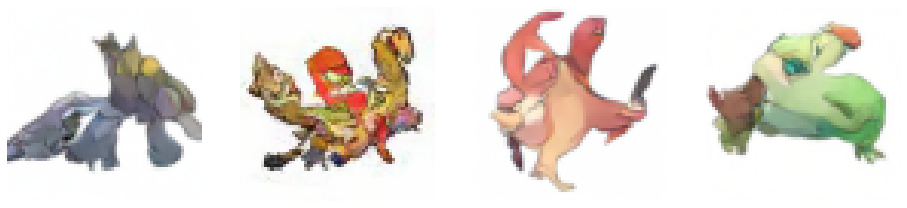

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    image = pipeline()["sample"]
    axs[i].imshow(image[0])
    axs[i].set_axis_off()
fig.show()


＜上記について＞

+ 画像サイズを64にしており、学習が回りやすくなっているはずだが、完成されたもののクオリティとしては大差ない（私は128）

    ↓

+ そもそも私同様に学習が不十分なままpushしたのか？
+ inputデータに偏りがあったのか？

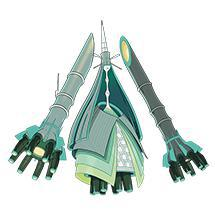

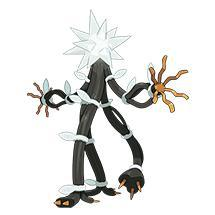

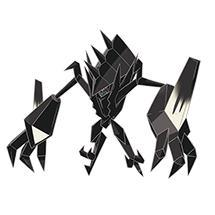

学習が十分でない可能性も考えられるが、こういったデータを抜いた方が、よかった可能性はあると思われる